# Train and evaluate a PC

In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cpu")  # The device to use, e.g., "cpu", "cuda", "cuda:1"

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if 'cuda' in device.type:
    torch.cuda.manual_seed(42)

## Load MNIST Dataset

In [4]:
from torchvision import transforms, datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (255 * x.view(-1)).long())
])
data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)
num_variables = data_train[0][0].shape[0]

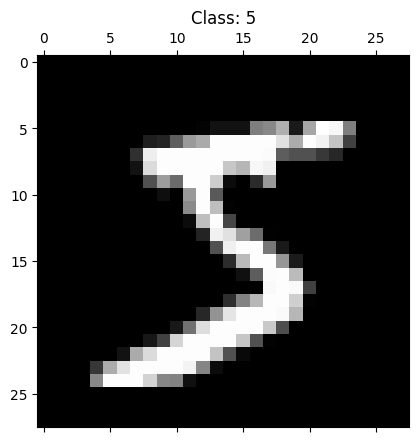

In [5]:
plt.matshow(data_train[0][0].reshape(28, 28), cmap='gray')
plt.title(f"Class: {data_train[0][1]}")
plt.show()

## Instantiating the region graph

In [6]:
from cirkit.region_graph.random_binary_tree import RandomBinaryTree

In [7]:
region_graph = RandomBinaryTree(num_variables, depth=3, num_repetitions=8)

## Choosing the layers

In [8]:
from cirkit.layers.exp_family import CategoricalLayer
from cirkit.layers.sum_product import CPLayer
efamily_cls = CategoricalLayer
efamily_kwargs = {'num_categories': 256}
layer_cls = CPLayer
layer_kwargs = {'rank': 1, 'prod_exp': True}

## Building the tensorized PC

In [9]:
from cirkit.models.tensorized_circuit import TensorizedPC

In [10]:
model = TensorizedPC(
    region_graph,
    num_inner_units=2,
    num_input_units=2,
    efamily_cls=efamily_cls,
    efamily_kwargs=efamily_kwargs,
    layer_cls=layer_cls,
    layer_kwargs=layer_kwargs
)
model.to(device)
model

TensorizedPC(
  (input_layer): CategoricalLayer()
  (inner_layers): ModuleList(
    (0-2): 3 x CPLayer()
    (3): MixingLayer()
  )
)

## Training and testing

In [11]:
from torch import optim
from torch.utils.data import DataLoader
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [12]:
num_epochs = 25
for epoch_idx in tqdm(range(num_epochs)):
    running_loss = 0.0
    for batch, _ in train_dataloader:
        log_score = model.forward(batch)
        log_pf = model.partition_function()
        lls = log_score - log_pf
        loss = -torch.mean(lls)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss * len(batch)
    print(f"Epoch {epoch_idx}: Average NLL: {running_loss / len(x_train):.3f}")

  0%|                                                                                                                                                                                                        | 0/25 [00:00<?, ?it/s]


AssertionError: 

In [ ]:
with torch.no_grad():
    model.eval()
    log_pf = model.partition_function()
    lls = 0.0
    for batch, _ in tqdm(test_dataloader):
        log_score = model.forward(batch)
        log_pf = model.partition_function()
        lls = log_score - log_pf
        lls += lls.sum().item()
    average_ll = lls / len(x_test)
    print(f"Average test LL: {average_ll:.3f}")